In [155]:
using Pkg 

Pkg.activate("..")

using MiCRM_stability
using LinearAlgebra
using StatsBase
using Distributions
using JLD2
using Random
using Graphs

using CairoMakie

  Activating project at `~/Projects/MiCRM_stability`
Precompiling Graphs
  ✓ ArnoldiMethod
  ✓ Graphs
  2 dependencies successfully precompiled in 4 seconds. 20 already precompiled.


In [3]:
#get parameter names
names =  vcat(fieldnames(MiCRM_stability.exponential_params)...,
    fieldnames(MiCRM_stability.structural_params)...)

#latex names
fe_L = [L"g_x",L"g_s",L"g_w",L"m_x",L"f_y",L"h_y",L"\lambda_y",L"i_y",L"o_y"]
fs_L = [L"\alpha",L"\beta",L"\Lambda",L"\rho",L"\tilde{\rho}",L"\sigma",L"\tilde{\sigma}",L"\gamma",L"\eta",L"\chi",L"\phi",L"\psi"]

#concatanate
names = string.(names)
names_L = vcat(fe_L,fs_L)

#filter parameters
p_ind = collect(1:21)
rm_ind = findall(names .∈ Ref(["α","β","γ","η","χ","ϕ","ψ","Λ"]))
p_ind = filter(x -> x .∉ Ref(rm_ind), p_ind)

#filter name vectors
names = names[p_ind]
names_L = names_L[p_ind]

#load
res = load("../Results/data/new_sims/dynamic_stabiltiy.jld2")

Dict{String, Any} with 2 entries:
  "l" => Complex[0.323069+0.0im, -0.00201049+0.0im, 0.484957+0.0im, 0.0399252+0…
  "p" => Any[[0.861587, 2.86918, -2.28569, 1.36374, 1.0, 1.0, 0.0, 1.81879, 0.7…

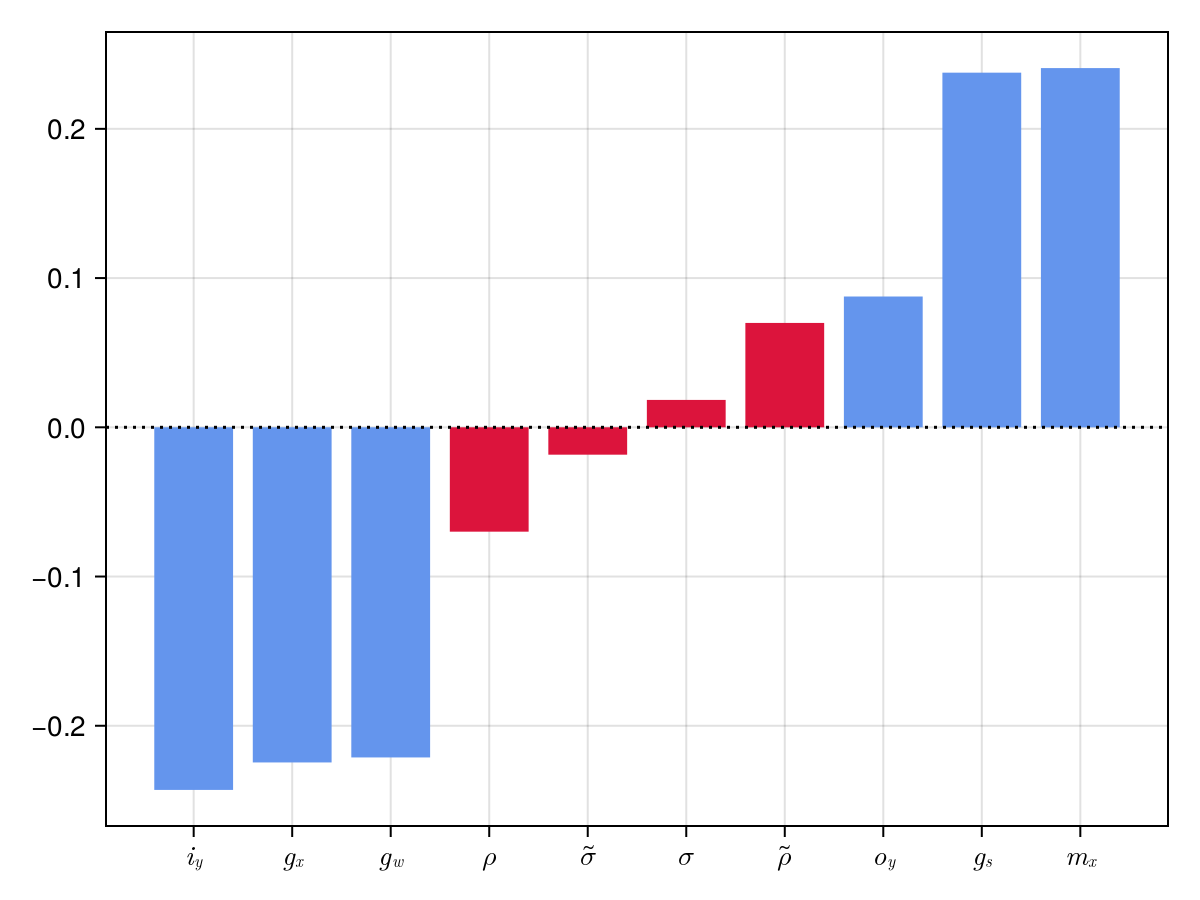

In [4]:
#get stability and correlate
p_mat = hcat(res["p"]...)[p_ind,:]
stab = [x.re < 0 for x = res["l"]]
stability_cor = [cor(abs.(p),stab) for p = eachrow(p_mat)]

#get color
c = vcat(fill(:cornflowerblue, length(fe_L)), fill(:crimson, length(fs_L)))
c = c[p_ind]

#sort
ind = sortperm(stability_cor)

f = Figure()
ax = Axis(f[1,1], xticks = (1:length(names), names_L[ind]) )
barplot!(ax, stability_cor[ind], color = c[ind])
hlines!(ax, [0], linestyle = :dot, color = "black")
f

In [5]:
#get parameter names
names =  vcat(fieldnames(MiCRM_stability.exponential_params)...,
    fieldnames(MiCRM_stability.structural_params)...)

#latex names
fe_L = [L"g_x",L"g_s",L"g_w",L"m_x",L"f_y",L"h_y",L"\lambda_y",L"i_y",L"o_y"]
fs_L = [L"\alpha",L"\beta",L"\Lambda",L"\rho",L"\tilde{\rho}",L"\sigma",L"\tilde{\sigma}",L"\gamma",L"\eta",L"\chi",L"\phi",L"\psi"]

#concatanate
names = string.(names)
names_L = vcat(fe_L,fs_L)

#filter parameters
p_ind = collect(1:21)
keep_ind = findall(names .∈ Ref(["fy","hy","λy","Λ"]))
p_ind = filter(x -> x .∈ Ref(keep_ind), p_ind)

#filter name vectors
names = names[p_ind]
names_L = names_L[p_ind]

#load
res = load("../Results/data/new_sims/switching_stabiltiy.jld2")

Dict{String, Any} with 2 entries:
  "l" => Complex[0.265756+0.0im, 0.112357+0.0im, 15.6144+0.0im, 13.0263+0.0im, …
  "p" => Any[[0.938055, 1.93189, -1.6984, 1.08933, 1.13645, 0.925925, -0.767274…

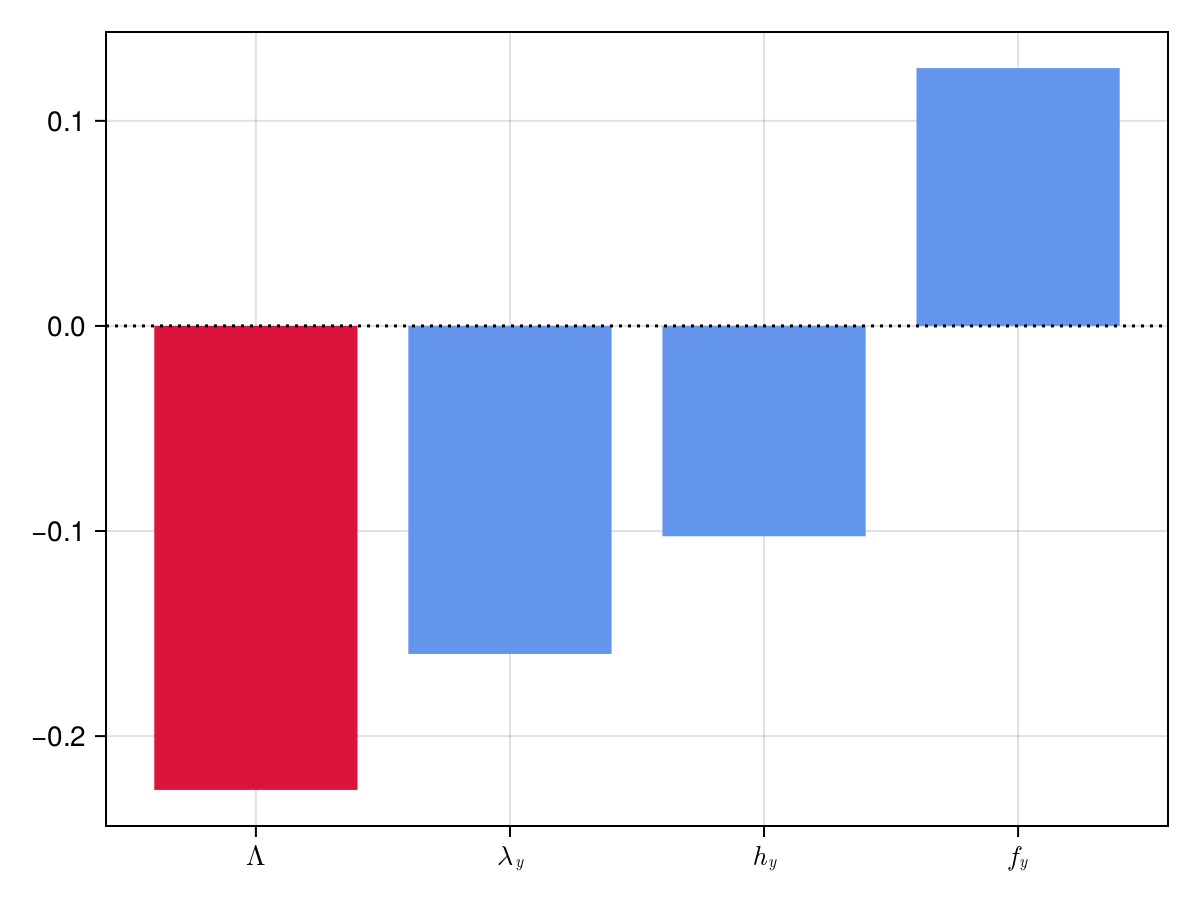

In [6]:
#get stability and correlate
p_mat = hcat(res["p"]...)[p_ind,:]
stab = [x.re < 0 for x = res["l"]]
stability_cor = [cor(abs.(p),stab) for p = eachrow(p_mat)]

#get color
c = vcat(fill(:cornflowerblue, length(fe_L)), fill(:crimson, length(fs_L)))
c = c[p_ind]

#sort
ind = sortperm(stability_cor)

f = Figure()
ax = Axis(f[1,1], xticks = (1:length(names), names_L[ind]) )
barplot!(ax, stability_cor[ind], color = c[ind])
hlines!(ax, [0], linestyle = :dot, color = "black")
f

In [117]:
res = load("../Results/data/new_sims/D_struct_stabiltiy.jld2")

stab_vec = [x.re < 0 for x = res["l"]]

mean(stab_vec, dims = 1)


1×2 Matrix{Float64}:
 0.798  0.793

In [132]:
#functions for simulations
function get_exponential_parameters(N,M,σ)
    gx = rand(Uniform(σ,1.0)) .+ rand(Uniform(-σ,σ), N)
    gs = rand(Uniform(1.0,2.0)) .+ rand(Uniform(-σ,σ), N)
    gw = -rand(Uniform(σ,1.0)) .+ rand(Uniform(-σ,σ), N)
    mx = rand(Uniform(0.5,1.0)) .+ rand(Uniform(-σ,σ), N)
    
    fy = ones(N,M)
    hy = ones(N,M)

    λy = zeros(N,M)

    iy = rand(Uniform(σ,1.0)) .+ rand(Uniform(-σ,σ), M)
    oy = rand(Uniform(1.0,2.0)) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,iy,oy)
end

function random_community1(N,M, f)
    #generate a coherent stoic matrix
    D = coherence_D(M,Int(0.1 * M),1,0.0001)
    D_shuff = shuffle(D)

    [D_shuff[i,:] .= D_shuff[i,:] ./ sum(D_shuff[i,:]) for i = 1:M]
    D_shuff[isnan.(D_shuff)] .= 0
    
    [D[i,:] .= D[i,:] ./ sum(D[i,:]) for i = 1:M]
    D[isnan.(D)] .= 0

    #generate 
    
    Λ = fill(rand(),N)
    
    s = MiCRM_stability.get_structural_params(U,D,Λ)
    s_shuff = MiCRM_stability.get_structural_params(U,D_shuff,Λ)

    e = f(N,M, 0.1)
    u = MiCRM_stability.util_params(N,M,s,e)
    
    p = MiCRM_stability.Parameters(N,M,s,e,u)
    p_shuff = MiCRM_stability.Parameters(N,M,s_shuff,e,u)

    return(p,p_shuff)
end

function get_param_mean(p::MiCRM_stability.Parameters)
    fe = fieldnames(MiCRM_stability.exponential_params)
    fs = fieldnames(MiCRM_stability.structural_params)
    
    ue = mean.(getfield.(Ref(p.e), fe))
    us = mean.(getfield.(Ref(p.s), fs))

    vcat(ue..., us...) 
end

function get_real(x::T) where T <: AbstractFloat
    x
end

get_real(x::Complex) = x.re


#params
N=100
M=100
Np = 50

p_vec = Vector{Any}(undef,Np)
stability = zeros(Np,2)

k = [0]

Threads.@threads for i = 1:Np
    k[1] += 1
    print("\r",k)
    
    p = random_community1(N,M, get_exponential_parameters)


    # p_vec[i] = get_param_mean(p)
    J = zeros(N+M, N+M)

    for j = 1:2
        MiCRM_stability.jacobian!(p[j],J)
        stability[i,j] = get_real(eigen(J).values[end])
    end
end

# mean(stability .< 0)

[50]

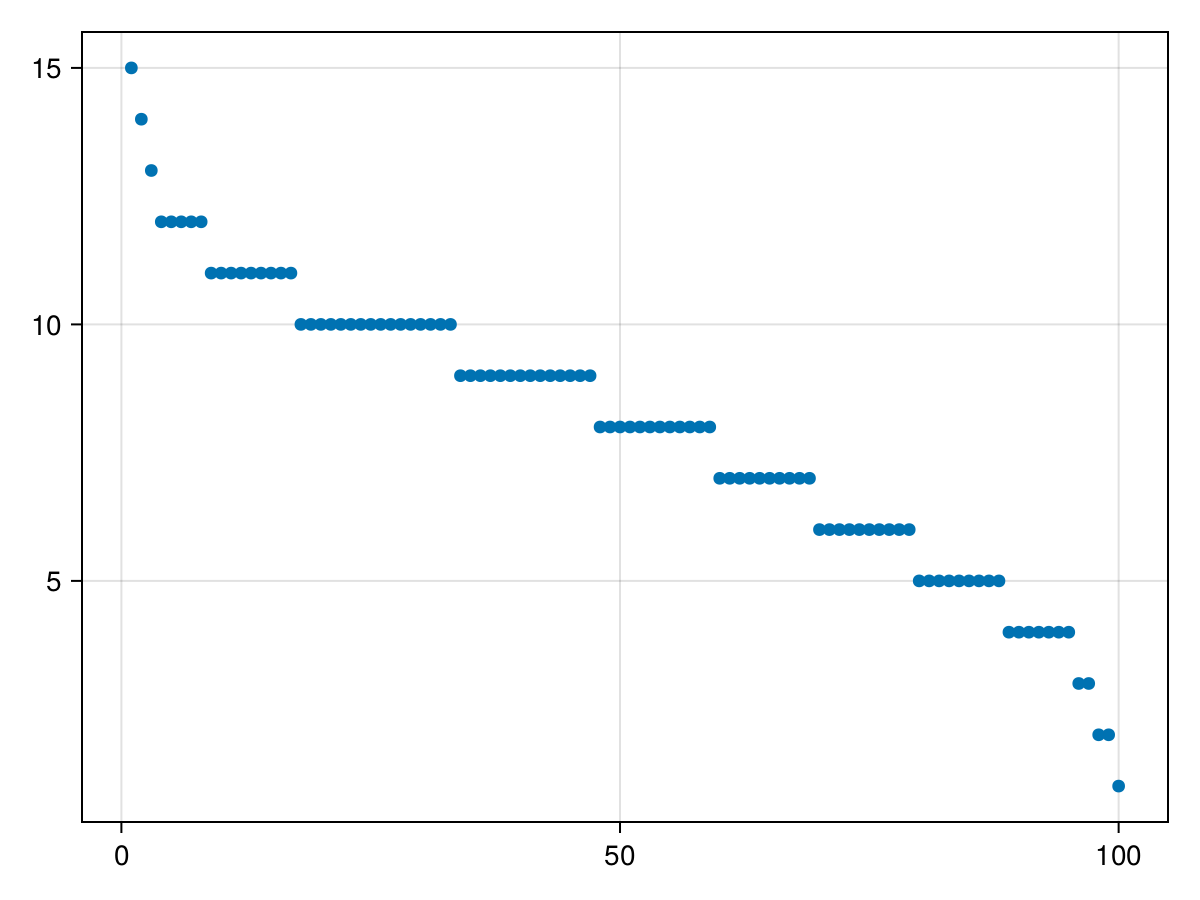

In [139]:
 D = coherence_D(M,Int(0.1 * M),1,0.0001)

# MiCRM_stability.get_TL(D) 

In [129]:
U

LoadError: UndefVarError: `U` not defined

In [38]:
#coherence of metabolite networks
function coherence_D(M,λd,h,T)
    #create skeleton
    TL = fill(-Inf,M)
    TL[1] = 1
    
    D = zeros(M,M)
    p = 0
    for i = 2:M
        ind = 1:(i-1)
    #choose base
        pb = (TL[ind] / maximum(TL[ind])) .^ h
        b = sample(ind, Weights(pb[ind]))
        D[b,i] = 1
        TL[i] = TL[b] + 1
    end
    
    #sort by TL
    TLind = sortperm(TL)
    D = D[TLind, TLind]
    TL = TL[TLind]
    
    #add extra links
    k = rand(Poisson(λd), M)
    x = TL .- TL'
    pl = exp.(-abs.(x .- 1)/ T)
    pl[findall(D .== 1)] .= 0
    pl[diagind(pl)] .= 0
    
    for i = 2:M
        D[sample(1:M, Weights(pl[i,:]), k[i]), i] .= 1
    end
    
    return(D)
end

coherence_D (generic function with 1 method)

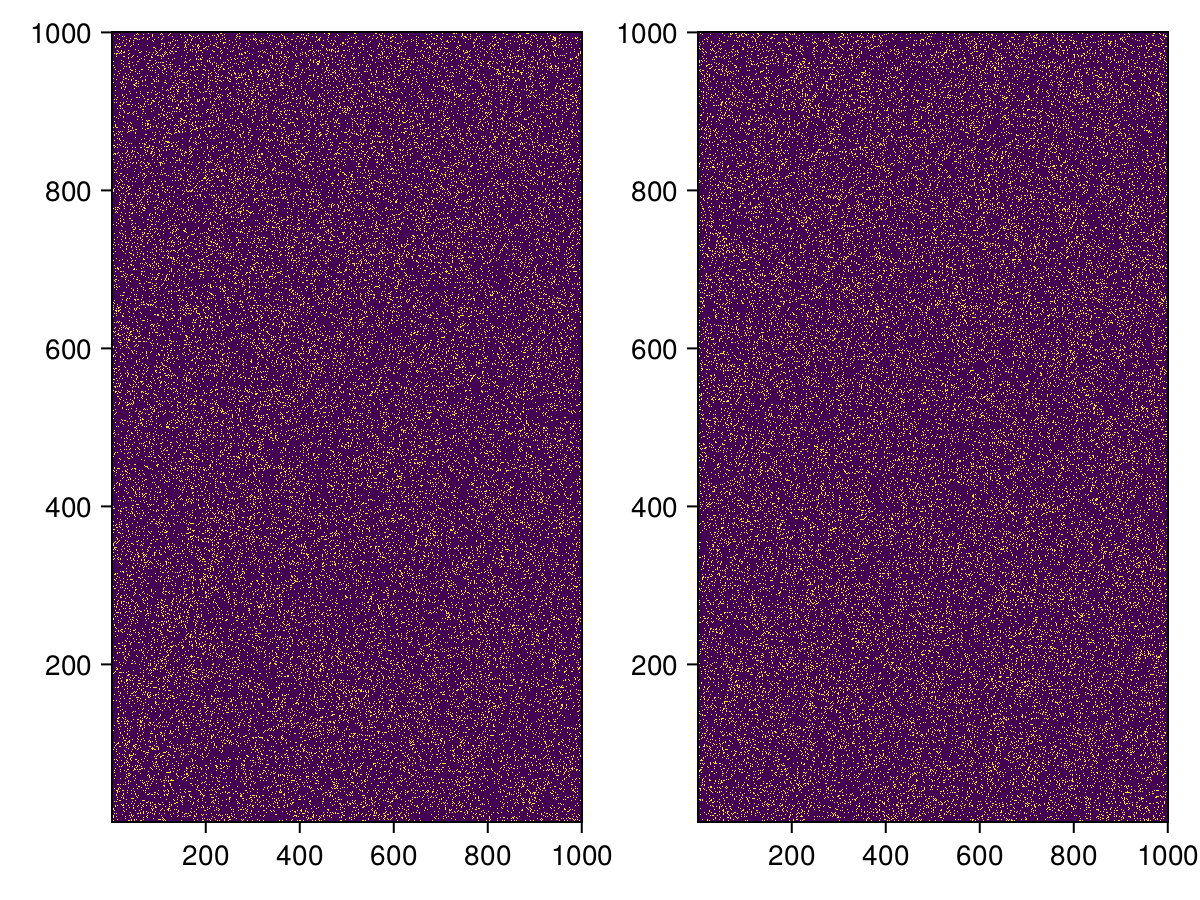

In [273]:
N,M = 1000, 1000
D = coherence_D(M,Int(0.1*M),1,100)

# # function coherence_U(N,D)
#get distance matrix for resources
#create symetric adjecency and apply dijkstra
g = SimpleGraph(D .+ D' .> 0 )
d_mat = hcat([x.dists for x = dijkstra_shortest_paths.(Ref(g), vertices(g))]...)

#find focal resources and sample based on distance on the metabolite network
s_ind = rand(1:M, N) |> sort
p_mat = exp.(-d_mat[s_ind,:]/ 10)
k = rand(Poisson(Int(0.1*M)), N)

U = zeros(N,M)
for i = 1:N
    U[i,sample(1:M, Weights(p_mat[i,:]), k[i], replace = false)] .= 1.0
end
    
f,ax = heatmap(D)
heatmap!(Axis(f[1,2]),U)
f

In [265]:
samlple(p_mat

1000×1000 Matrix{Float64}:
 3.72008e-44   1.0          3.72008e-44  …  5.1482e-131   5.1482e-131
 3.72008e-44   3.72008e-44  1.0             5.1482e-131   5.1482e-131
 3.72008e-44   3.72008e-44  3.72008e-44     1.91517e-174  1.91517e-174
 3.72008e-44   3.72008e-44  3.72008e-44     1.91517e-174  5.1482e-131
 3.72008e-44   3.72008e-44  3.72008e-44     1.91517e-174  1.91517e-174
 3.72008e-44   3.72008e-44  3.72008e-44  …  5.1482e-131   5.1482e-131
 3.72008e-44   3.72008e-44  3.72008e-44     5.1482e-131   5.1482e-131
 3.72008e-44   3.72008e-44  3.72008e-44     5.1482e-131   5.1482e-131
 3.72008e-44   3.72008e-44  3.72008e-44     5.1482e-131   5.1482e-131
 3.72008e-44   3.72008e-44  3.72008e-44     5.1482e-131   1.91517e-174
 3.72008e-44   3.72008e-44  3.72008e-44  …  5.1482e-131   1.91517e-174
 3.72008e-44   3.72008e-44  3.72008e-44     5.1482e-131   1.91517e-174
 3.72008e-44   3.72008e-44  3.72008e-44     5.1482e-131   1.91517e-174
 ⋮                                       ⋱               

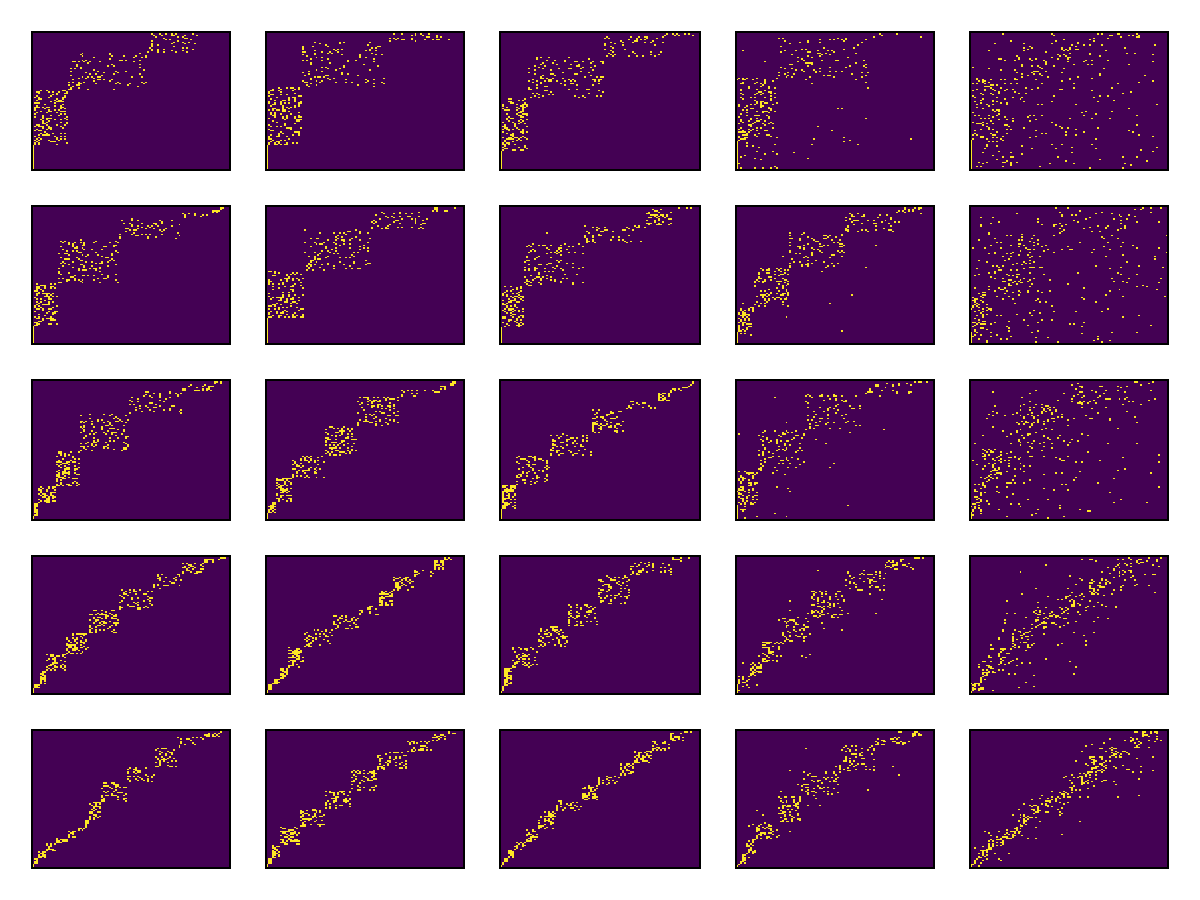

In [290]:
M = 100
λd = 3.0

h_vec = range(-2,2, length = 5)
T_vec = 10 .^ range(-2,0, length=5)

f = Figure()

for i = 1:5
    for j= 1:5
        ax = Axis(f[i,j])
        hidedecorations!(ax)
        heatmap!(ax, coherence_D(M,λd,h_vec[i],T_vec[j]))
    end
end
f

In [335]:
function get_switching_parameters(N,M,σ)

    gx = rand(Uniform(0.75,1.0)) .+ rand(Uniform(-σ,σ), N)
    gs = rand(Uniform(1,2)) .+ rand(Uniform(-σ,σ), N)
    gw = -rand(Uniform(1,2)) .+ rand(Uniform(-σ,σ), N)
    mx = rand(Uniform(1.0,1.25)) .+ rand(Uniform(-σ,σ), N)
    
    fy = rand(Uniform(σ,2)) .+ rand(Uniform(-σ,σ),N,M)
    hy = rand(Uniform(σ,2)) .+ rand(Uniform(-σ,σ),N,M)

    # fy = ones(N,M)
    # hy = ones(N,M)
    
    λy = rand(Uniform(-1,1)) .+ rand(Uniform(-σ,σ),N,M)
    # ωy = rand(Uniform(-1,1)) .+ rand(Uniform(-σ,σ),N,M)
    # λy = zeros(N,M)

    iy = rand(Uniform(σ,0.5)) .+ rand(Uniform(-σ,σ), M)
    oy = rand(Uniform(1.0,2.0)) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,iy,oy)
end

function coherence_D(M,λd,h,T)
    #create skeleton
    TL = fill(-Inf,M)
    TL[1] = 1
    
    D = zeros(M,M)
    p = 0
    for i = 2:M
        ind = 1:(i-1)
    #choose base
        pb = (TL[ind] / maximum(TL[ind])) .^ h
        b = sample(ind, Weights(pb[ind]))
        D[b,i] = 1
        TL[i] = TL[b] + 1
    end
    
    #sort by TL
    TLind = sortperm(TL)
    D = D[TLind, TLind]
    TL = TL[TLind]
    
    #add extra links
    k = rand(Poisson(λd), M)
    x = TL .- TL'
    pl = exp.(-abs.(x .- 1)/ T)
    pl[findall(D .== 1)] .= 0
    pl[diagind(pl)] .= 0
    
    for i = 2:M
        D[sample(1:M, Weights(pl[i,:]), k[i]), i] .= 1
    end
    
    return(D)
end

function random_community(N,M,f,h,T)
    U = rand(N,M) ./ (N*M)
    U[:,end] .= 0
    
    D = coherence_D(M,3.0,h,T)
    [D[i,:] .= D[i,:] ./ sum(D[i,:]) for i = 1:M]
    D[isnan.(D)] .= 0.0
    
    Λ = fill(rand(),N)
    
    s = MiCRM_stability.get_structural_params(U,D,Λ)
    e = f(N,M, 0.1)
    u = MiCRM_stability.util_params(N,M,s,e)
    
    p = MiCRM_stability.Parameters(N,M,s,e,u)

    return(p)
end

random_community (generic function with 1 method)

In [334]:
N,M = 50,100
U = rand(N,M) ./ (N*M)
U[:,end] .= 0

D = coherence_D(M,3.0,h,T)
[D[i,:] .= D[i,:] ./ sum(D[i,:]) for i = 1:M]
D[isnan.(D)] .= 0.0

Λ = fill(rand(),N)

s = MiCRM_stability.get_structural_params(U,D,Λ)

s.ψ

50×100×100 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0